In [16]:
#
# Author: J.G. Messchendorp, October 2020
#

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl

from sklearn import neighbors               # includes kNN!
from random import uniform as random_uniform

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Update the matplotlib configuration parameters:
mpl.rcParams.update({'font.size': 20, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

In [17]:
#
# Read the comma-seperated datafile and print first 10 entries
# "data" is of type DataFrame
#
data = pd.read_csv('fruit.csv')
data.head(10)

,fruitid,fruitname,colorid,colorname,elongatedness,weight,sweetness,acidity
0,1,orange,2,brown,0.14,152,3.56,1095
1,1,orange,2,brown,0.09,167,3.33,1080
2,1,orange,2,brown,0.15,152,4.00,1035
3,1,orange,2,brown,0.03,155,3.00,680
4,1,orange,2,brown,0.08,147,2.69,1020
5,1,orange,2,brown,0.14,147,3.55,1045
6,1,orange,2,brown,0.14,152,3.33,985
7,1,orange,2,brown,0.18,159,2.88,1515
8,1,orange,3,green,0.08,152,3.17,1185
9,1,orange,4,orange,0.18,174,3.03,1120


In [18]:
#
# normalize features and add them to the dataset
#

data['elongatedness_normal'] = ( data.elongatedness - data.elongatedness.mean() ) / data.elongatedness.std()
data['weight_normal']        = ( data.weight        - data.weight.mean() )        / data.weight.std()
data['sweetness_normal']     = ( data.sweetness     - data.sweetness.mean() )     / data.sweetness.std()
data['acidity_normal']       = ( data.acidity       - data.acidity.mean() )       / data.acidity.std()

In [19]:
#
# Check that the normalization makes sense
#
data[['elongatedness_normal', 'weight_normal', 'sweetness_normal', 'acidity_normal']].describe()

,elongatedness_normal,weight_normal,sweetness_normal,acidity_normal
count,1.790000e+02,1.790000e+02,1.790000e+02,1.790000e+02
mean,7.939025e-17,-5.954269e-16,3.969512e-17,-1.587805e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.706801e+00,-2.040430e+00,-1.876399e+00,-1.488391e+00
25%,-9.039453e-01,-7.956576e-01,-9.564810e-01,-7.789503e-01
50%,-1.010901e-01,-6.954036e-02,2.443281e-01,-2.349399e-01
75%,8.252814e-01,6.047114e-01,7.920656e-01,7.608219e-01
max,2.430992e+00,2.783063e+00,1.957763e+00,2.971859e+00


In [4]:
#
# The engine code behind the ML algorithm used in this example.
# We make use of kNN classifier:
#

def kNN_classify(data, 
                 k=15, 
                 prop_test=0.3, 
                 feature_list=['acidity_normal','sweetness_normal'],
                 plot_ds=False):
    """
    Use kNN algorithm to classify dataset data. Use feature list feature_list
    and use prop_test fraction of the data as test sample, rest for training.
    The function returns an updated dataset including a column with predicted class.
    """
    
    assert 0<prop_test<1
     
    #
    # make a copy of the dataframe. The original table will not be altered.
    #
    data_tmp = data.copy()
    #
    # Add a column specifying whether event is used for training or for testing
    #
    data_tmp['is_train'] = np.random.uniform(0, 1, len(data_tmp)) <= (1-prop_test)
    #
    # Extract two seperate datasets for training (train) and testing (test)
    #
    train, test = data_tmp[data_tmp['is_train']==True], data_tmp[data_tmp['is_train']==False]
    
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(k)
    clf.fit(train[feature_list],train['fruitid'])
    
    #evaluate the training points
    trainpred = clf.predict(train[feature_list])
    train['prediction'] = [x for x in trainpred]
   
    # Predict on the testing points       
    testpred = clf.predict(test[feature_list])
    test['prediction'] = [x for x in testpred]
 
    data_update = train.append(test)
     
    if (plot_ds) & (len(feature_list)==2):
        plot_decision_surface(clf,data_update,feature_list)
        
    return data_update

#
# getNrOfSuccesses(dataFrame): returns fraction of succesfull classifications for training and test 
#                              part of the data table
#

def getNrOfSuccesses(data):
    """
    Reads as input DataFrame "data" and return the fraction of successfull classifications of
    the training and test part of the table. This function only works with an updated DataFrame
    that includes the columns "is_train" and "prediction", generated by kNN_classify() function.
    """
    
    nrtrain_instances = len(data[(data.is_train == True)])
    nrtest_instances  = len(data[(data.is_train == False)])
    
    nrtrain_success = len(data[(data.is_train == True)  & (data.prediction == data.fruitid)])
    nrtest_success  = len(data[(data.is_train == False) & (data.prediction == data.fruitid)])
    
    return (nrtrain_success/nrtrain_instances), (nrtest_success/nrtest_instances)

#
# plot_decision_surface: function that creates decision surface based on classifier clf
# and features in feature_list of dataFrame data. It uses "meshgrid" of numpy to generate
# grid of points to evaluate by classifier. For plotting, it uses "pcolormesh" of matplotlib.
#

def plot_decision_surface(clf, data, feature_list, step=0.02):
    """
    Function that creates a decision surface of classifier "clf"
    together with features from the two entries of the "features_list" of "data"
    """
    X = data[feature_list[0]].values
    Y = data[feature_list[1]].values
    
    # colors associated with the three classes, light is used for surface and bold for datapoints
    cmap_light = ListedColormap(['#ffde9e', '#b8ea9d', '#ffbaba'])
    cmap_bold  = ListedColormap(['#ff8c28', '#11bb11', '#ff0000'])
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max] x [y_min, y_max].
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Plot the data points
    plt.scatter(X, Y, s=40, c=data['fruitid'], cmap=cmap_bold)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.show()
    return

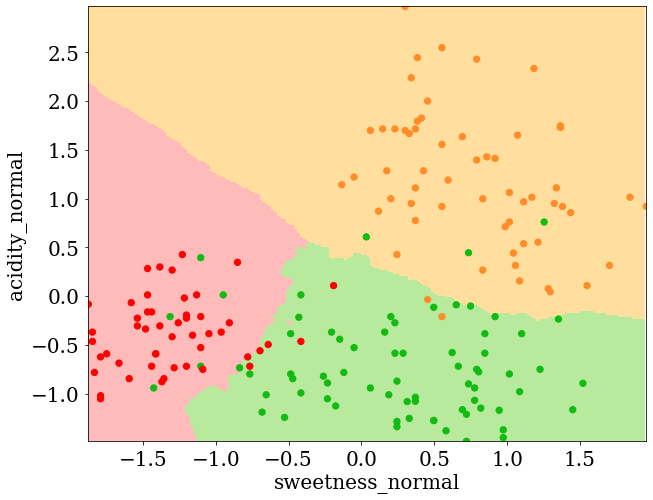

     fruitid fruitname  colorid colorname  elongatedness  weight  sweetness  \
0          1    orange        2     brown           0.14     152       3.56   
2          1    orange        2     brown           0.15     152       4.00   
3          1    orange        2     brown           0.03     155       3.00   
4          1    orange        2     brown           0.08     147       2.69   
5          1    orange        2     brown           0.14     147       3.55   
..       ...       ...      ...       ...            ...     ...        ...   
155        3     apple        5       red           0.19     167       1.56   
165        3     apple        6    yellow           0.23     180       1.62   
166        3     apple        6    yellow           0.23     159       1.29   
175        3     apple        6    yellow           0.25     141       1.58   
178        3     apple        6    yellow           0.28     129       1.86   

     acidity  elongatedness_normal  weight_normal  

In [20]:
#
# Let's test kNN_classify function, and see what new dataFrame it creates
#

k            = 10
prop_test    = 0.3
feature_list = ['sweetness_normal','acidity_normal']
plot_ds      = True

data_new = kNN_classify(data, k, prop_test, feature_list, plot_ds)
print(data_new)

train_success, test_success = getNrOfSuccesses(data_new)
print('Success rate: ', train_success, test_success)

In [21]:
#
# Piece of code that performs cross validation and returns for each validation the success rates
#
def kNN_test(data=data, 
             k=15, 
             reps=1, 
             prop_test=0.3, 
             feature_list=['acidity_normal','sweetness_normal'], 
             plot_ds=False):
    """ 
    Function that performs a kNN classification for "reps" cross validations. It returns the error rate for
    train and test samples.
    """
    
    assert 0<prop_test<1
      
    train_result = []
    test_result  = []
        
    for rep in range(reps):
      
        dn = kNN_classify(data=data, k=k, prop_test=prop_test, feature_list=feature_list, plot_ds=plot_ds)
        
        success_train, success_test = getNrOfSuccesses(dn)
        
        train_result.append(success_train)
        test_result.append(success_test)
        
    return [train_result, test_result]

In [23]:
#
# Let's run a kNN test for some value of "k" and for 10 cross validations with default parameters
#
kNN_test(data,k=30,reps=10)

[[0.9298245614035088,
  0.9133858267716536,
  0.9186991869918699,
  0.9230769230769231,
  0.917910447761194,
  0.9256198347107438,
  0.8943089430894309,
  0.9105691056910569,
  0.916030534351145,
  0.9112903225806451],
 [0.8615384615384616,
  0.9038461538461539,
  0.9107142857142857,
  0.8979591836734694,
  0.8666666666666667,
  0.8793103448275862,
  0.9642857142857143,
  0.9285714285714286,
  0.8333333333333334,
  0.8909090909090909]]

In [28]:
#
# Try to find the optimum value of "k".
# Hence run the kNN_test for several values of "k" and study the resulting error rate
#
klist = np.arange(1,100,2)                             # list of k-values to study
features_sel = ['acidity_normal','sweetness_normal','elongatedness_normal','weight_normal']   # list of input features ,'weight_normal','elongatedness_normal'

k_result = []
for k in klist:
    result = kNN_test(data=data, k=k, reps=30, prop_test=0.3, feature_list=features_sel)
    train_error = 1 - np.mean(result[0]) # take the average of all the cross validations as result
    test_error  = 1 - np.mean(result[1]) # ...same for test samples
    k_result.append([train_error,test_error])

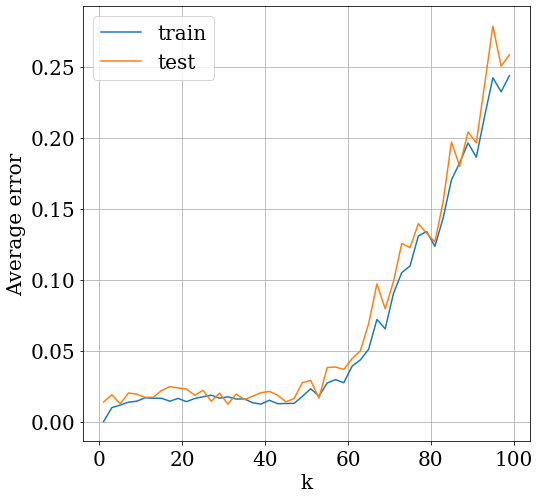

In [29]:
#
# Plot the fraction of classification errors versus "k" for training and test part of the dataset
#
plt.figure(figsize=(8, 8))
plt.plot(klist, np.transpose(k_result)[0],label='train')
plt.plot(klist, np.transpose(k_result)[1],label='test')
plt.xlabel('k')
plt.ylabel('Average error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [30]:
#
# Another metric that is often used to evaluate the performace
# of a classifier such as kNN, is the "confusion matrix".
# This matrix contains additional info about true negatives/positives, false positives/negatives etc.
#
from sklearn.metrics import confusion_matrix # Make use of what is available in sklearn, no need to re-invent the wheel ;-)

# Run kNN for a specific conditions...
k = 20
prop_test = 0.3
feature_list = ['acidity_normal','sweetness_normal']
data_new = kNN_classify(data, k, prop_test, feature_list)

# Extract the column with true labels and predicted labels, only for instances labeled as "test"
labels_true = data_new[data_new['is_train']==False][['fruitid']].values
labels_pred = data_new[data_new['is_train']==False][['prediction']].values

# fruitnames = ['orange', 'pear', 'apple'] # Reminder about labels 1,2, and 3.
#
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples 
# with true label being i-th class and prediced label being j-th class.
#
cm = confusion_matrix(labels_true, labels_pred, labels=[1, 2, 3])
print(cm)

[[25  1  0]
 [ 2 20  3]
 [ 0  3 11]]


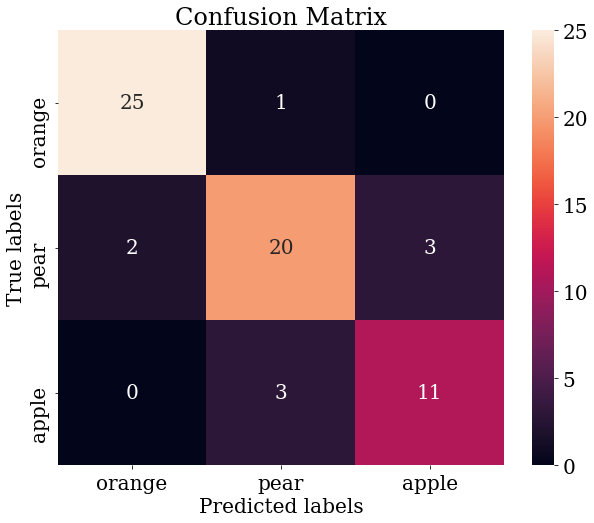

In [31]:
#
# Let's make the confusion matrix more fancier in looks!
# I made use of heatmap functionality offered by "seaborn" module.
# Seaborn is a statistical data visualization toolset, not installed by default!
# To create annotated heatmaps with matplotlib directly, I refer to 
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
#
import seaborn as sns   

fruitnames = ['orange', 'pear', 'apple']

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
_ = ax.xaxis.set_ticklabels(fruitnames) 
_ = ax.yaxis.set_ticklabels(fruitnames)